# Comparison of correlation networks with biological reactions

This notebook loads the correlation matrices generated by imp_comparison_conditions.ipynb and the linex networks generated by Linex_create_networks.ipynb. The pairwise ion correlations are classified according to whether they are present in the linex network or not. These two classes of network are then compared.

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=28, progress_bar=True, use_memory_fs=False)

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
# importing custom functions for imputation and evaluation
import sys

sys.path.append("/home/mklein/sc_imputation_denoising")

from sc_imputation_denoising.imputation.constants import const

# from sc_imputation_denoising.evaluation.evaluation_workflow import (
#     evaluation_workflow,
# )
# from sc_imputation_denoising.imputation.simulation import (
#     get_dropout_rate,
# )

In [4]:
import math


def round_significant(num, sigfigs):
    if num == 0:
        return 0
    elif np.abs(num) == float("inf"):
        return num
    try:
        result = round(num, -int(math.floor(math.log10(abs(num)))) + sigfigs - 1)
        return result
    except:
        type(num)
        print(num)

In [17]:
hue_orders = {
    "layer": ["ctrl", "MAGIC_t3", "dca_nb"],
    "corr_method": ["pearson", "spearman"],
}

In [5]:
datasets = dict(
    Mx_Seahorse=dict(c=0.1, i=0.2, repl=1, cond=4),
    Lx_Pancreatic_Cancer=dict(c=0.2, i=0.05, repl=1, cond=4),
    Lx_Glioblastoma=dict(c=0.05, i=0.05, repl=4, cond=6),
    Lx_HepaRG=dict(c=0.2, i=0.2, repl=5, cond=4),
)
dataset = "Lx_Glioblastoma"
params = datasets[dataset]
sim_method = "mnar"
sparse = False


if sparse:
    sparse_text = "_sparse"
else:
    sparse_text = ""

max_fdr = 1
conf = f"cond{params['cond']}_{sim_method}_c{params['c']}_i{params['i']}_fdr{max_fdr}_repl{params['repl']}"
save_to = f"/g/alexandr/Marius/imputation_evaluation/{dataset}_{conf}"
if not os.path.exists(save_to):
    print("sample does not exist")
    # os.makedirs(save_to)
print(save_to)

/g/alexandr/Marius/imputation_evaluation/Lx_Glioblastoma_cond6_mnar_c0.05_i0.05_fdr1_repl4


In [6]:
const.NARROW_BBOX.update(fc=(1, 1, 1, 0.6))
linex_folder = "/scratch/klein/linex_comparison"
if not os.path.exists(os.path.join(linex_folder, dataset)):
    os.makedirs(os.path.join(linex_folder, dataset))

ds_path = os.path.join(linex_folder, dataset)

In [7]:
from tqdm import tqdm

tqdm.pandas()

assoc_list = []

for corr_method in ["pearson", "spearman"]:
    print(corr_method)
    corr_df = pd.read_csv(
        os.path.join(save_to, f"nonzero_correlation_{corr_method}{sparse_text}.csv"),
        index_col=[0, 1],
        header=[0, 1],
    )

    # corr_df = corr_df.replace(np.nan, 0)
    # if corr_method != "cosine":
    #     corr_df = (corr_df + 1) / 2
    def save_to_csv(df, filename):
        df.to_csv(filename)

    def save_to_csv(df, dataset, imputation, corr_method, condition, force=False):
        filename = os.path.join(ds_path, f"{condition}_{corr_method}_{imputation}.csv")
        if not os.path.exists(filename) or force:
            df.dropna().to_csv(filename)

        return dict(
            dataset=dataset,
            condition=condition,
            corr_method=corr_method,
            imputation=imputation,
            filename=filename,
        )

    assoc_df = corr_df.progress_apply(
        lambda x: save_to_csv(
            x,
            dataset=dataset,
            imputation=x.name[0],
            corr_method=corr_method,
            condition=x.name[1],
            force=False,
        )
    )

    assoc_list.append(assoc_df)

pearson


100%|██████████| 48/48 [00:00<00:00, 3173.30it/s]


spearman


100%|██████████| 48/48 [00:00<00:00, 2147.12it/s]


In [24]:
long_corr_df = pd.concat([pd.json_normalize(elem) for elem in assoc_list])

In [25]:
linex_path = f"/home/mklein/Dropouts/tests/linex/{dataset}.graphml"
long_corr_df["linex_path"] = linex_path
linex_path

'/home/mklein/Dropouts/tests/linex/Lx_Glioblastoma.graphml'

In [26]:
from scipy.stats import ttest_ind, mannwhitneyu


def stratified_edge_analysis(row, save_plot=False, get_data=False, net_method=None):
    linex_network_path = row["linex_path"]

    try:
        linex_network = nx.read_graphml(linex_network_path)
    except:
        return dict()

    for u, v, weight in linex_network.edges.data("weight"):
        linex_network.edges[u, v]["weight"] = float(weight)

    if "corr_df" in row.keys():
        corr_matrix = row["corr_df"]
        if net_method == "signed" and row["corr_method"] in ["pearson", "spearman"]:
            corr_matrix = (1 + corr_matrix) / 2
        elif net_method == "signed hybrid":
            corr_matrix[corr_matrix < 0] = 0
        ions = set(list(corr_matrix["ion1"])).union(list(corr_matrix["ion2"]))
        common_nodes = list(ions.intersection(linex_network.nodes()))
        if len(common_nodes) == 0:
            raise Exception("no overlap between linex net and corr matrix")

        linex_network_c = linex_network.subgraph(common_nodes)
        linex_adj = pd.DataFrame(
            nx.adjacency_matrix(linex_network_c).todense(),
            columns=linex_network_c.nodes,
            index=linex_network_c.nodes,
        )
        corr_edges_df = corr_matrix[
            (corr_matrix["ion1"].isin(common_nodes))
            & (corr_matrix["ion2"].isin(common_nodes))
        ]

        corr_edges_df = corr_edges_df.set_index(["ion1", "ion2"])
    elif "filename" in row.keys():
        corr_matrix = pd.read_csv(
            row["filename"], index_col=[0, 1], header=[0, 1]
        ).reset_index()

        ions = set(list(corr_matrix["ion1"])).union(list(corr_matrix["ion2"]))
        common_nodes = list(ions.intersection(linex_network.nodes()))
        if len(common_nodes) == 0:
            raise Exception("no overlap between linex net and corr matrix")

        linex_network_c = linex_network.subgraph(common_nodes)
        linex_adj = pd.DataFrame(
            nx.adjacency_matrix(linex_network_c).todense(),
            columns=linex_network_c.nodes,
            index=linex_network_c.nodes,
        )
        corr_edges_df = corr_matrix[
            (corr_matrix["ion1"].isin(common_nodes))
            & (corr_matrix["ion2"].isin(common_nodes))
        ]

        corr_edges_df = corr_edges_df.set_index(["ion1", "ion2"])
    else:
        raise NotImplementedError("can't accept other data than corr matrix")

    linex_adj_lower = pd.DataFrame(
        # np.tril(linex_adj.values), columns=linex_adj.columns, index=linex_adj.index
        linex_adj.values,
        columns=linex_adj.columns,
        index=linex_adj.index,
    )

    linex_edges_df = pd.DataFrame(linex_adj_lower.stack())
    linex_edges_df.columns = ["linex_weight"]
    linex_edges_df = linex_edges_df[linex_edges_df["linex_weight"] != 0]
    linex_edges_df["linex"] = True
    linex_edges_df.index.names = ["ion1", "ion2"]

    corr_edges_df.columns = ["edge_weight"]
    corr_edges_df = corr_edges_df[corr_edges_df["edge_weight"] != 0].dropna()

    matched_edge_df = pd.merge(
        corr_edges_df, linex_edges_df, left_index=True, right_index=True, how="left"
    )
    matched_edge_df["linex"] = matched_edge_df["linex"].replace(np.nan, False)
    test_res = ttest_ind(
        matched_edge_df.loc[matched_edge_df["linex"] == True, "edge_weight"],
        matched_edge_df.loc[matched_edge_df["linex"] == False, "edge_weight"],
        equal_var=False,
    )

    wilcox_statistic, wilcox_pval = mannwhitneyu(
        matched_edge_df.loc[matched_edge_df["linex"] == True, "edge_weight"],
        matched_edge_df.loc[matched_edge_df["linex"] == False, "edge_weight"],
        alternative="two-sided",
    )

    row["t_fold_change"] = (
        matched_edge_df.loc[matched_edge_df["linex"] == True, "edge_weight"].mean()
        / matched_edge_df.loc[matched_edge_df["linex"] == False, "edge_weight"].mean()
    )
    row["t_statistic"] = test_res.statistic
    row["t_pvalue"] = test_res.pvalue
    row["w_statistic"] = wilcox_statistic
    row["w_pvalue"] = wilcox_pval

    row["n_in_linex"] = len(
        matched_edge_df.loc[matched_edge_df["linex"] == True, "edge_weight"]
    )
    row["n_not_in_linex"] = len(
        matched_edge_df.loc[matched_edge_df["linex"] == False, "edge_weight"]
    )

    if save_plot:
        if row["corr_method"] == "cosine":
            text = f"cosine similarity /\nedge weight"
        else:
            text = f"scaled {row['corr_method']} correlation /\nedge weight"
        fig, ax = plt.subplots(1, 1, figsize=(3, 4))
        sns.violinplot(
            data=matched_edge_df, x="linex", y="edge_weight", cut=0, inner=None, ax=ax
        )
        sns.stripplot(
            data=matched_edge_df,
            x="linex",
            y="edge_weight",
            jitter=True,
            color="black",
            size=2,
            ax=ax,
        )
        ax.set_title(
            # f"t statistic={round_sign(test_res.statistic, 3)}, pval={round_sign(test_res.pvalue, 3)}" +
            # f"\nwilcox statistic={round_sign(wilcox_statistic, 3)}, pval={round_sign(wilcox_pval, 3)}, " +
            f"\nFC={round_significant(row['t_fold_change'], 3)}\n"
            + f"\nimputation = {row['imputation']}"
        )
        ax.set_xlabel("edges with biological evidence")
        ax.set_ylabel(text)
        ax.set_ylim(0, 1)

        fig.savefig(os.path.join(save_to, f"linex_match_plot_{row['corr_method']}.pdf"))
        print(
            "saved plot to "
            + os.path.join(save_to, f"linex_match_plot_{row['corr_method']}.pdf")
        )

    if get_data:
        return (row, matched_edge_df)
    else:
        matched_edge_df.to_csv(row["filename"][:-4] + "_linex.csv")
        return row


# row = clust_df.loc[81]
# hi = stratified_edge_analysis(row, save_plot=True, get_data=False)
# print(hi)

In [27]:
res_list = []
stat_list = []
for lab, elem in tqdm(long_corr_df.iterrows()):
    row = stratified_edge_analysis(elem, save_plot=False, get_data=False)
    # row, data = stratified_edge_analysis(elem, save_plot=False, get_data=True)
    # data["imputation"] = elem["imputation"]
    # data["condition"] = elem["condition"]
    # data["corr_method"] = elem["corr_method"]
    # res_list.append(data)

    stat_list.append(row)

96it [06:14,  3.90s/it]


In [28]:
stat_df = pd.DataFrame(stat_list)
stat_df

,dataset,condition,corr_method,imputation,filename,linex_path,t_fold_change,t_statistic,t_pvalue,w_statistic,w_pvalue,n_in_linex,n_not_in_linex
0,Lx_Glioblastoma,TMD_sM,pearson,ALRA,/scratch/klein/linex_comparison/Lx_Glioblastom...,/home/mklein/Dropouts/tests/linex/Lx_Glioblast...,1.064606,17.485499,8.755197e-65,507299906.5,8.017283e-83,2549,325906
1,Lx_Glioblastoma,TMD_dM,pearson,ALRA,/scratch/klein/linex_comparison/Lx_Glioblastom...,/home/mklein/Dropouts/tests/linex/Lx_Glioblast...,1.065482,15.991013,5.958598e-55,497621789.5,9.606393e-65,2549,326717
2,Lx_Glioblastoma,TMD_CD95_WT,pearson,ALRA,/scratch/klein/linex_comparison/Lx_Glioblastom...,/home/mklein/Dropouts/tests/linex/Lx_Glioblast...,1.060633,14.577316,2.585954e-46,493234809.5,3.940059e-58,2549,326717
3,Lx_Glioblastoma,TMD_tM,pearson,ALRA,/scratch/klein/linex_comparison/Lx_Glioblastom...,/home/mklein/Dropouts/tests/linex/Lx_Glioblast...,1.077276,15.934106,1.371160e-54,500243897.5,7.177045e-69,2549,326717
4,Lx_Glioblastoma,TMD_CD95_KO,pearson,ALRA,/scratch/klein/linex_comparison/Lx_Glioblastom...,/home/mklein/Dropouts/tests/linex/Lx_Glioblast...,1.078965,18.508717,6.559136e-72,512774678.5,2.169176e-90,2549,326717
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,Lx_Glioblastoma,TMD_dM,spearman,knn_5,/scratch/klein/linex_comparison/Lx_Glioblastom...,/home/mklein/Dropouts/tests/linex/Lx_Glioblast...,0.972114,-7.324474,3.188269e-13,382716399.0,1.834460e-12,2549,326717
44,Lx_Glioblastoma,TMD_CD95_WT,spearman,knn_5,/scratch/klein/linex_comparison/Lx_Glioblastom...,/home/mklein/Dropouts/tests/linex/Lx_Glioblast...,0.973721,-6.689845,2.728238e-11,384946016.0,4.701238e-11,2549,326717
45,Lx_Glioblastoma,TMD_tM,spearman,knn_5,/scratch/klein/linex_comparison/Lx_Glioblastom...,/home/mklein/Dropouts/tests/linex/Lx_Glioblast...,0.965638,-8.760107,3.457071e-18,372520515.0,4.334117e-20,2549,326717
46,Lx_Glioblastoma,TMD_CD95_KO,spearman,knn_5,/scratch/klein/linex_comparison/Lx_Glioblastom...,/home/mklein/Dropouts/tests/linex/Lx_Glioblast...,0.978911,-5.480235,4.657768e-08,391002617.0,1.077710e-07,2549,326717


In [29]:
from statsmodels.stats.multitest import multipletests

corr_res_df = stat_df
corr_res_df["adj_pvalue"] = multipletests(corr_res_df["t_pvalue"], method="fdr_bh")[1]
corr_res_df["w_adj_pvalue"] = multipletests(corr_res_df["w_pvalue"], method="fdr_bh")[1]

corr_res_df["-log pval"] = -np.log10(corr_res_df["adj_pvalue"])
corr_res_df["-log pval (wilcox)"] = -np.log10(corr_res_df["w_adj_pvalue"])
corr_res_df["logFC"] = np.log2(corr_res_df["t_fold_change"])
corr_res_df.to_csv(
    os.path.join(
        "/home/mklein/Dropouts/tests/linex",
        f"linex_match_results_{dataset}{sparse_text}.csv",
    )
)
corr_res_df

,dataset,condition,corr_method,imputation,filename,linex_path,t_fold_change,t_statistic,t_pvalue,w_statistic,w_pvalue,n_in_linex,n_not_in_linex,adj_pvalue,w_adj_pvalue,-log pval,-log pval (wilcox),logFC
0,Lx_Glioblastoma,TMD_sM,pearson,ALRA,/scratch/klein/linex_comparison/Lx_Glioblastom...,/home/mklein/Dropouts/tests/linex/Lx_Glioblast...,1.064606,17.485499,8.755197e-65,507299906.5,8.017283e-83,2549,325906,5.603326e-64,5.131061e-82,63.251554,81.289793,0.090320
1,Lx_Glioblastoma,TMD_dM,pearson,ALRA,/scratch/klein/linex_comparison/Lx_Glioblastom...,/home/mklein/Dropouts/tests/linex/Lx_Glioblast...,1.065482,15.991013,5.958598e-55,497621789.5,9.606393e-65,2549,326717,2.860127e-54,4.009625e-64,53.543615,63.396896,0.091506
2,Lx_Glioblastoma,TMD_CD95_WT,pearson,ALRA,/scratch/klein/linex_comparison/Lx_Glioblastom...,/home/mklein/Dropouts/tests/linex/Lx_Glioblast...,1.060633,14.577316,2.585954e-46,493234809.5,3.940059e-58,2549,326717,8.560401e-46,1.454791e-57,45.067506,56.837199,0.084926
3,Lx_Glioblastoma,TMD_tM,pearson,ALRA,/scratch/klein/linex_comparison/Lx_Glioblastom...,/home/mklein/Dropouts/tests/linex/Lx_Glioblast...,1.077276,15.934106,1.371160e-54,500243897.5,7.177045e-69,2549,326717,6.268162e-54,3.444981e-68,53.202860,67.462813,0.107388
4,Lx_Glioblastoma,TMD_CD95_KO,pearson,ALRA,/scratch/klein/linex_comparison/Lx_Glioblastom...,/home/mklein/Dropouts/tests/linex/Lx_Glioblast...,1.078965,18.508717,6.559136e-72,512774678.5,2.169176e-90,2549,326717,4.497693e-71,1.601853e-89,70.347010,88.795377,0.109648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,Lx_Glioblastoma,TMD_dM,spearman,knn_5,/scratch/klein/linex_comparison/Lx_Glioblastom...,/home/mklein/Dropouts/tests/linex/Lx_Glioblast...,0.972114,-7.324474,3.188269e-13,382716399.0,1.834460e-12,2549,326717,4.435853e-13,2.412441e-12,12.353023,11.617543,-0.040803
44,Lx_Glioblastoma,TMD_CD95_WT,spearman,knn_5,/scratch/klein/linex_comparison/Lx_Glioblastom...,/home/mklein/Dropouts/tests/linex/Lx_Glioblast...,0.973721,-6.689845,2.728238e-11,384946016.0,4.701238e-11,2549,326717,3.446196e-11,5.861284e-11,10.462660,10.232007,-0.038419
45,Lx_Glioblastoma,TMD_tM,spearman,knn_5,/scratch/klein/linex_comparison/Lx_Glioblastom...,/home/mklein/Dropouts/tests/linex/Lx_Glioblast...,0.965638,-8.760107,3.457071e-18,372520515.0,4.334117e-20,2549,326717,5.926407e-18,7.052123e-20,17.227208,19.151680,-0.050445
46,Lx_Glioblastoma,TMD_CD95_KO,spearman,knn_5,/scratch/klein/linex_comparison/Lx_Glioblastom...,/home/mklein/Dropouts/tests/linex/Lx_Glioblast...,0.978911,-5.480235,4.657768e-08,391002617.0,1.077710e-07,2549,326717,5.807087e-08,1.293252e-07,7.236042,6.888317,-0.030751


In [30]:
hue_dict = {
    "baseline": (0.6257796880873904, 0.7692334467518679, 0.8490464152850072),
    "ctrl": (0.31288984404369524, 0.5944206449445615, 0.746091835093484),
    "ctrl_nonzero": (0.0, 0.4196078431372549, 0.6431372549019608),
    "fancy_itersvd": (0.976249987924192, 0.7208024833334978, 0.4948461379450622),
    "fancy_multi": (1.0, 0.5019607843137255, 0.054901960784313725),
    "knn_3": (0.6450787385143271, 0.6450943494613806, 0.6450330062267311),
    "knn_5": (0.34901960784313724, 0.34901960784313724, 0.34901960784313724),
    "ALRA": (0.37254901960784315, 0.6196078431372549, 0.8196078431372549),
    "MAGIC_t1": (0.8679748929727327, 0.6302059588557253, 0.46777925759729744),
    "MAGIC_t3": (0.7843137254901961, 0.3215686274509804, 0.0),
    "dca_nb": (0.7395654837909705, 0.7395810602898067, 0.7395199624957123),
    "dca_zinb": (0.5372549019607843, 0.5372549019607843, 0.5372549019607843),
}

palette = {
    key: value
    for key, value in hue_dict.items()
    if key in corr_res_df["imputation"].unique()
}
palette

{'ctrl': (0.31288984404369524, 0.5944206449445615, 0.746091835093484),
 'ctrl_nonzero': (0.0, 0.4196078431372549, 0.6431372549019608),
 'fancy_itersvd': (0.976249987924192, 0.7208024833334978, 0.4948461379450622),
 'fancy_multi': (1.0, 0.5019607843137255, 0.054901960784313725),
 'knn_5': (0.34901960784313724, 0.34901960784313724, 0.34901960784313724),
 'ALRA': (0.37254901960784315, 0.6196078431372549, 0.8196078431372549),
 'MAGIC_t3': (0.7843137254901961, 0.3215686274509804, 0.0),
 'dca_nb': (0.7395654837909705, 0.7395810602898067, 0.7395199624957123)}

In [31]:
stat_df["annotated_filename"] = [f[:-4] + "_linex.csv" for f in stat_df.filename]
data_list = []
# for i, row in stat_df[stat_df.condition == 'Naive_WT'].iterrows():
for i, row in stat_df.iterrows():
    f = row["annotated_filename"]

    if not os.path.exists(f):
        print(f + " does not exist")
        continue

    df = pd.read_csv(f, index_col=[0, 1])
    df["imputation"] = row["imputation"]
    df["condition"] = row["condition"]
    df["corr_method"] = row["corr_method"]
    df["dataset"] = row["dataset"]
    data_list.append(df)

In [32]:
res_df = pd.concat(data_list)
res_df["conserved"] = res_df["linex"].map(
    {True: "biological reaction", False: "no biological reaction"}
)
res_df

edge_weight  linex_weight  linex imputation  \
ion1            ion2                                                         
C10H20NO8P+K    C21H38O3+H        0.397871           NaN  False       ALRA   
                C21H39O6P+H       0.484208           NaN  False       ALRA   
                C21H39O6P+Na      0.520569           NaN  False       ALRA   
                C21H40O3+H        0.492006           NaN  False       ALRA   
                C21H41O6P+Na      0.521785           NaN  False       ALRA   
...                                    ...           ...    ...        ...   
C58H112NO16P+Na C59H96O5+K        0.682005           NaN  False      knn_5   
                C61H98O5+K        0.776888           NaN  False      knn_5   
                C63H113O12P+K     0.669088           NaN  False      knn_5   
                C65H115O12P+K     0.810067           NaN  False      knn_5   
                C65H117O12P+K     0.845389           NaN  False      knn_5   

                              condition corr_method          dataset  \
ion1            ion2                                                   
C10H20NO8P+K    C21H38O3+H       TMD_sM     pearson  Lx_Glioblastoma   
                C21H39O6P+H      TMD_sM     pearson  Lx_Glioblastoma   
                C21H39O6P+Na     TMD_sM     pearson  Lx_Glioblastoma   
                C21H40O3+H       TMD_sM     pearson  Lx_Glioblastoma   
                C21H41O6P+Na     TMD_sM     pearson  Lx_Glioblastoma   
...                                 ...         ...              ...   
C58H112NO16P+Na C59H96O5+K     Naive_WT    spearman  Lx_Glioblastoma   
                C61H98O5+K     Naive_WT    spearman  Lx_Glioblastoma   
                C63H113O12P+K  Naive_WT    spearman  Lx_Glioblastoma   
                C65H115O12P+K  Naive_WT    spearman  Lx_Glioblastoma   
                C65H117O12P+K  Naive_WT    spearman  Lx_Glioblastoma   

                                            conserved  
ion1            ion2                                   
C10H20NO8P+K    C21H38O3+H     no biological reaction  
                C21H39O6P+H    no biological reaction  
                C21H39O6P+Na   no biological reaction  
                C21H40O3+H     no biological reaction  
                C21H41O6P+Na   no biological reaction  
...                                               ...  
C58H112NO16P+Na C59H96O5+K     no biological reaction  
                C61H98O5+K     no biological reaction  
                C63H113O12P+K  no biological reaction  
                C65H115O12P+K  no biological reaction  
                C65H117O12P+K  no biological reaction  

[31410447 rows x 8 columns]

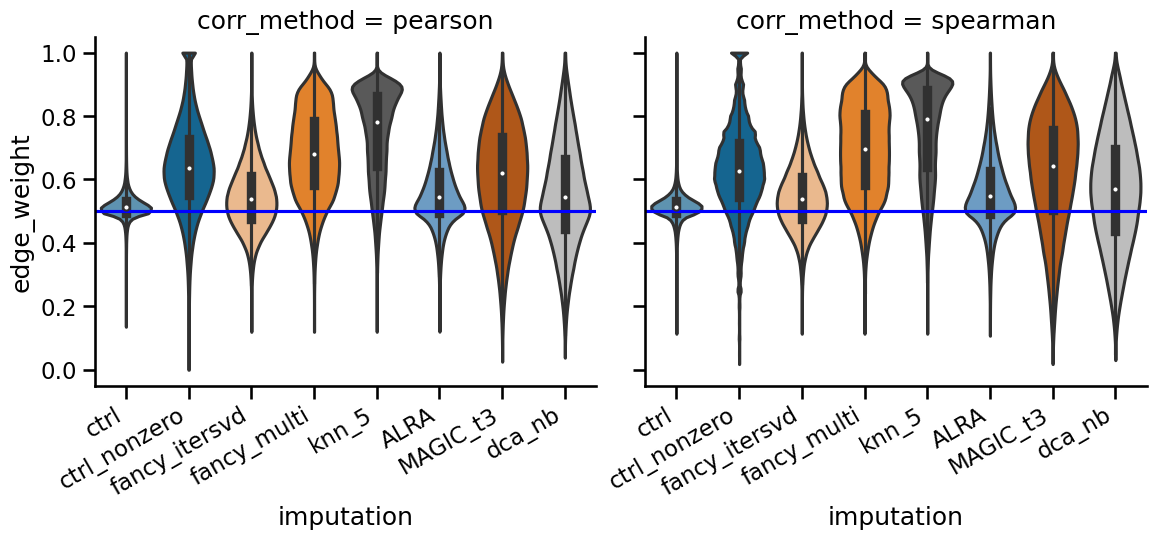

In [44]:

axisplot = sns.catplot(
    data=res_df[res_df['corr_method'] != 'cosine'],
    kind="violin",
    scale="width",
    cut=0,
    x="imputation", order = palette.keys(), palette=palette.values(),
    y="edge_weight",
    col="corr_method", col_order=hue_orders['corr_method'],
    aspect=1.2, height=5,
    split=True,
)

axisplot.set_xticklabels(rotation=30, ha='right')

for ax in axisplot.axes.flat:
    ax.axhline(0.5, color="blue")

In [34]:
mean_nonlinex_df = (
    res_df[res_df["linex"] == False]
    .groupby(["imputation", "corr_method", "condition"])[["edge_weight"]]
    .mean()
)
mean_nonlinex_df.to_csv(
    os.path.join(
        "/home/mklein/Dropouts/tests/linex", f"mean_nonlinex_{dataset}{sparse_text}.csv"
    )
)
mean_nonlinex_df

edge_weight
imputation corr_method condition               
ALRA       pearson     Naive_WT        0.564534
                       TMD_CD95_KO     0.564801
                       TMD_CD95_WT     0.572872
                       TMD_dM          0.551830
                       TMD_sM          0.562942
...                                         ...
knn_5      spearman    TMD_CD95_KO     0.763906
                       TMD_CD95_WT     0.765058
                       TMD_dM          0.765576
                       TMD_sM          0.780593
                       TMD_tM          0.743900

[96 rows x 1 columns]

/home/mklein/miniconda3/envs/corr_env/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/mklein/miniconda3/envs/corr_env/lib/python3.10/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/mklein/miniconda3/envs/corr_env/lib/python3.10/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


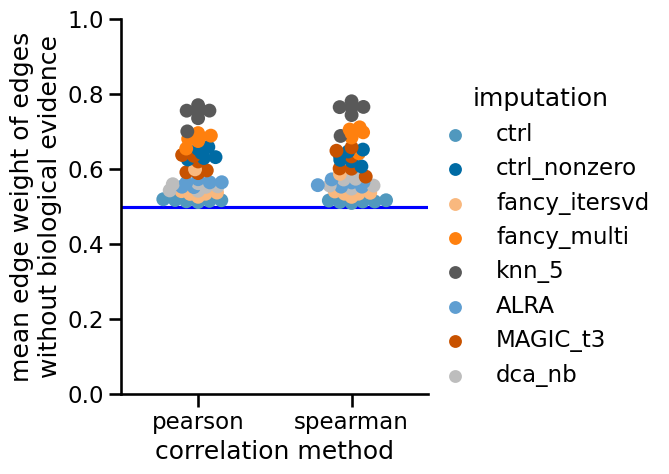

In [41]:
cat_df = sns.catplot(
    data=mean_nonlinex_df.reset_index(),
    y="edge_weight",
    x="corr_method",
    order=hue_orders["corr_method"],
    kind="swarm",
    hue="imputation",
    hue_order=palette.keys(),
    palette=palette.values(),
    height=5,
    s=10,
)
ax = cat_df.axes.flat[0]
ax.set_ylim(0, 1)
ax.axhline(0.5, color="blue")
# sns.move_legend(cat_df, "upper left", ncol=1, frameon=False, bbox_to_anchor=(0.2,1))
cat_df.set_ylabels("mean edge weight of edges\nwithout biological evidence")
cat_df.set_xlabels("correlation method")
cat_df.savefig(
    os.path.join(
        "/home/mklein/Dropouts/tests/linex/",
        "mean_edge_weight_{dataset}{sparse_text}.pdf",
    )
)

/home/mklein/miniconda3/envs/corr_env/lib/python3.10/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


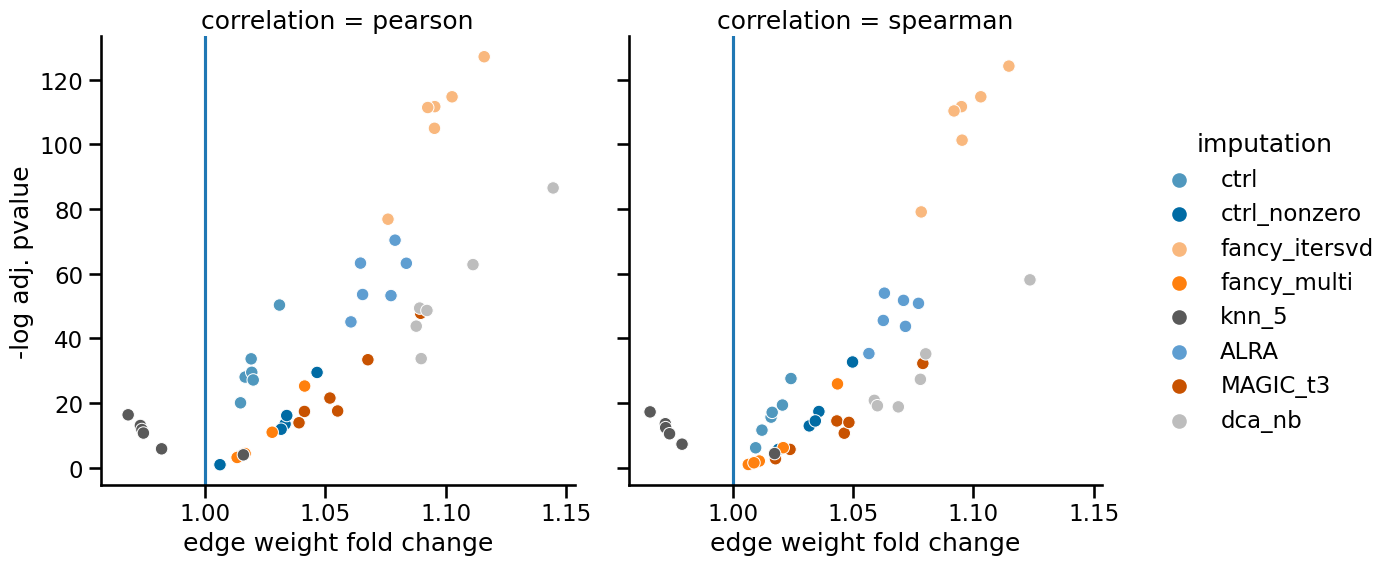

In [43]:
corr_res_df["-log pval"] = [min(130, -np.log10(p)) for p in corr_res_df["adj_pvalue"]]

volcano = sns.relplot(
    # data=corr_res_df[corr_res_df["corr_method"] != 'cosine'],
    data=corr_res_df,
    x="t_fold_change",
    y="-log pval",
    hue="imputation",
    col="corr_method",
    col_order=hue_orders["corr_method"],
    hue_order=palette.keys(),
    palette=palette.values(),
    # size='n_in_linex', sizes=(5, 150),
    # style='condition',
    alpha=1,
    height=6,
    aspect=1,
    facet_kws=dict(margin_titles=True),
)
axes = volcano.axes.flat
volcano.set_ylabels("-log adj. pvalue")
volcano.set_xlabels("edge weight fold change")
for ax in axes:
    ax.axvline(1)
# ax.axvline(-1)
# ax.axhline(2)
# ax.set_yscale("symlog", linthresh=5, linscale=5)
volcano.set_titles(col_template="correlation = {col_name}")
#sns.move_legend(volcano, "upper right", bbox_to_anchor=(0.34, 0.9))
volcano.savefig(
    os.path.join(
        "/home/mklein/Dropouts/tests/linex/", f"volcano_{dataset}{sparse_text}.pdf"
    )
)